# PREDICTIONS

TODOs
- Try CV with different sequence lengths: TSCV (sklearn or skforecast)
- Try MAPE and MASE as metrics
- Conformal Predictions 

## 0. Setup and Configuration

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

import sys
import os
sys.path.append(os.path.abspath('..'))


from src.data import TimeSeriesDataset, load_data, download_data, compute_features
from src.lstm import train_lstm, evaluate_lstm


# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
feature_cols = [
    "LogReturn",
    "RealisedVolatility",
    "RSI_14",
    "BB_Width",
    "MACD",
    "YZVolatility",
    "Log_CO",
    "Log_HL",
]
ticker = "TSLA"
start_date = "2015-01-01"
seq_len = 30

In [3]:
train_dataset, val_dataset, test_dataset = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.7,
    test_size=0.15,
)
# Print shapes of the datasets
print(f"Train shape: {len(train_dataset)}")
print(f"\t Train X shape: {train_dataset.X.shape}")
print(f"\t Train y shape: {train_dataset.y.shape}")
print(f"\t Train dates shape: {train_dataset.dates.shape}")
print(f"Validation shape: {len(val_dataset) if val_dataset else 0}")
print(f"Test shape: {len(test_dataset)}")

[*********************100%***********************]  1 of 1 completed


Train shape: 1885
	 Train X shape: torch.Size([1885, 30, 8])
	 Train y shape: torch.Size([1885, 1])
	 Train dates shape: (1885,)
Validation shape: 404
Test shape: 405


## 1. Explotary Analysis

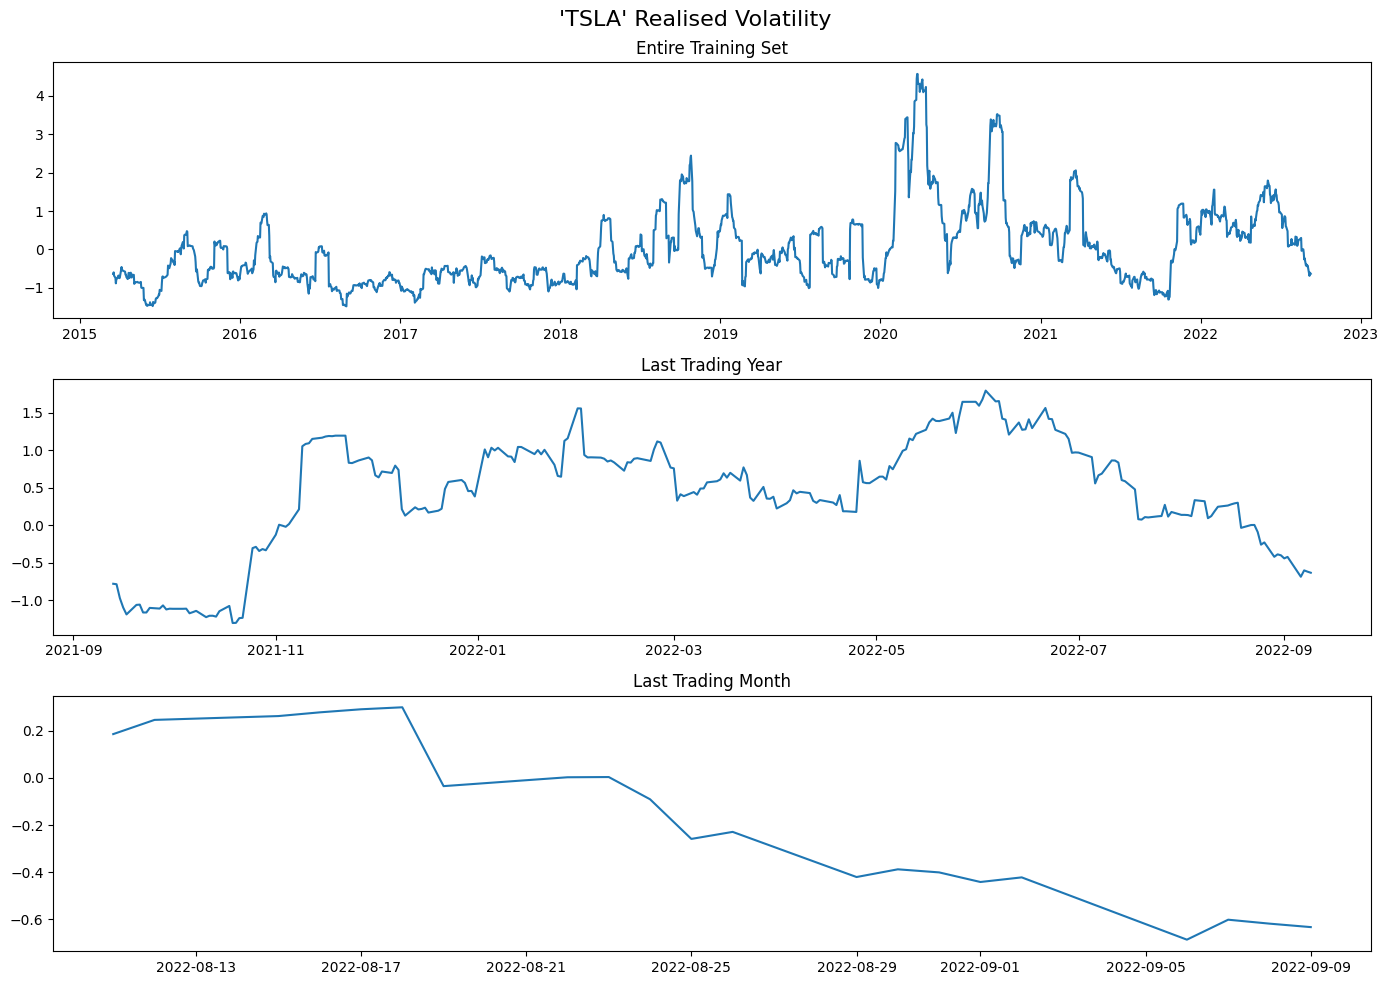

In [4]:
# 2) Basic plots: entire series, one month, a couple of days
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
# Title for the entire figure
fig.suptitle(f'\'{ticker}\' Realised Volatility', fontsize=16)
# Plot entire training set
ax[0].plot(train_dataset.dates, train_dataset.y, label='Realised Volatility')
ax[0].set_title('Entire Training Set')
# Zoom into last trading year (last available in training set)
ax[1].plot(train_dataset.dates[-251:], train_dataset.y[-251:], label='Realised Volatility')
ax[1].set_title('Last Trading Year')
# Zoom into last month
ax[2].plot(train_dataset.dates[-21:], train_dataset.y[-21:], label='Realised Volatility')
ax[2].set_title('Last Trading Month')
plt.tight_layout()
plt.show()

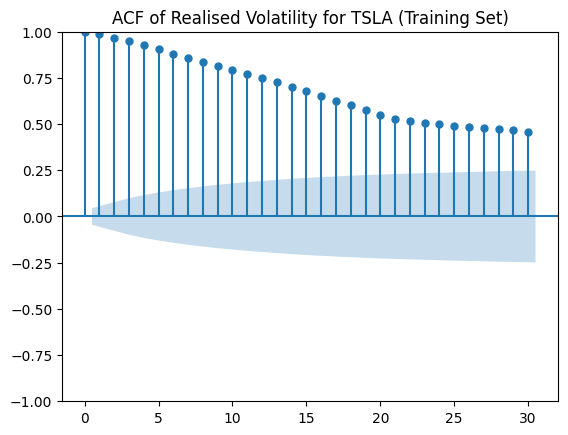

In [5]:
# Plot ACF of the target variable in the training set
plot_acf(train_dataset.y, lags=30)
plt.title(f'ACF of Realised Volatility for {ticker} (Training Set)')
plt.show()

## 2. Baseline Models
### 2.1 Naive Model

Naive Baseline:
	'Test' MAE:  0.101063
	'Test' RMSE: 0.213259


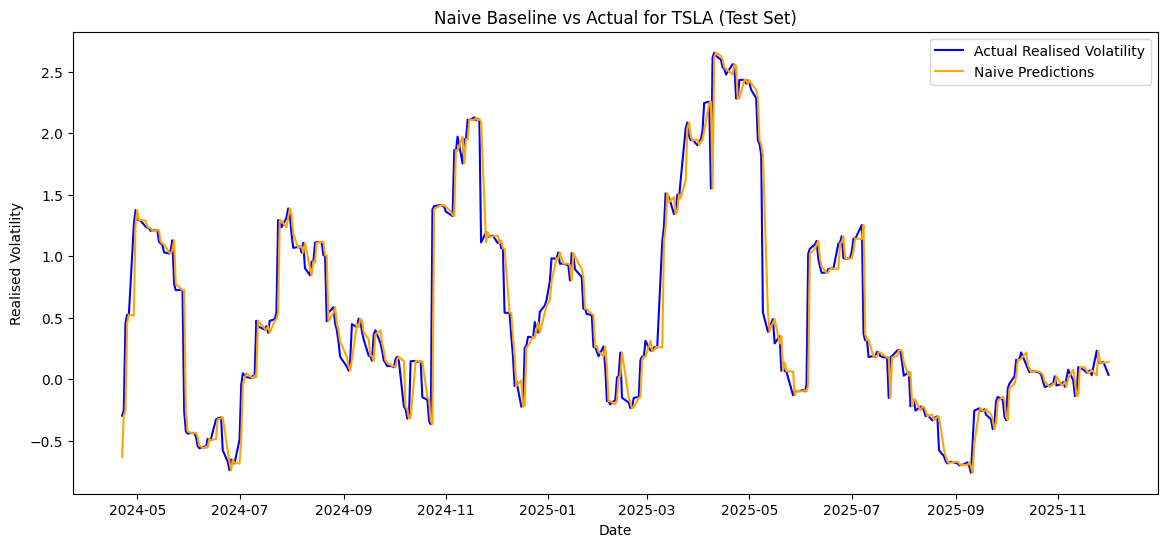

In [6]:
y_train = train_dataset.y
y_test  = test_dataset.y

# naive: y_pred[t] = y[t-1]
base_preds = np.empty_like(y_test)

# first test prediction = last training value
base_preds[0] = y_train[-1]

# the rest use previous test values
base_preds[1:] = y_test[:-1]

base_mae = mean_absolute_error(y_test, base_preds)
base_rmse = np.sqrt(mean_squared_error(y_test, base_preds))

print(f"Naive Baseline:")
print(f"\t'Test' MAE:  {base_mae:.6f}")
print(f"\t'Test' RMSE: {base_rmse:.6f}")

# Plot naive predictions vs actuals
plt.figure(figsize=(14, 6))
plt.plot(test_dataset.dates, y_test, label='Actual Realised Volatility', color='blue')
plt.plot(test_dataset.dates, base_preds, label='Naive Predictions', color='orange')
plt.title(f'Naive Baseline vs Actual for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

Such low values of MAE and RMSE might seem surprising, but if we look at the autocorrelation coefficient of the 1st lag below (also seen in the ACF plot), we can see that there is a very high correlation (0.99) between the current value and the previous value. This means that using the previous value as a prediction is quite effective in this case.

In [7]:
print(f"Autocorrelation Coefficient for lag 1 = {pd.Series(y_train.ravel()).autocorr(lag=1):.4f}")

Autocorrelation Coefficient for lag 1 = 0.9851


### 2.2 HAR-RV

Heterogenous Autoregressive Model for Realized Volatility (HAR-RV) is frequently used to model and forecast realized volatility. The HAR-RV model captures the long-memory property of volatility by incorporating realized volatility over different time horizons (daily, weekly, monthly) as predictors.

1. Intuition:
    Core idea: financial markets are heterogeneous, with participants operating on different time scales (short, medium and long-term traders)
2. Model Specification:
    The HAR-RV model can be expressed mathematically as:
    $$
    RV_{t+1} = \beta_0 + \beta_d RV_t^{(d)} + \beta_w RV_t^{(w)} + \beta_m RV_t^{(m)} + \epsilon_{t+1}
    $$
    Where:
    - $RV_t^{(d)} = RV_t$ is yesterday's RV.
    - $RV_t^{(w)} = \frac{1}{5} \sum_{i=0}^{4} RV_{t-i}$ is the average RV over the past week.
    - $RV_t^{(m)} = \frac{1}{22} \sum_{i=0}^{21} RV_{t-i}$ is the average RV over the past month.
    - $\beta_0, \beta_d, \beta _w, \beta_m$ are the model coefficients to be estimated.

In [8]:
rv = pd.Series(train_dataset.y.ravel(), index=train_dataset.dates)
rv_test = pd.Series(test_dataset.y.ravel(), index=test_dataset.dates)
full_rv = pd.concat([rv, rv_test])

lags = [1, 5, 22]  # daily, weekly, monthly
# Daily Lag
full_rv_lag0 = full_rv.shift(lags[0])

# Weekly Lag
full_rv_lag1 = full_rv.rolling(window=lags[1]).mean().shift(1)

# Monthly Lag
full_rv_lag2 = full_rv.rolling(window=lags[2]).mean().shift(1)

har_data = pd.DataFrame({
    'RV': full_rv,
    f'RV_Lag{lags[0]}': full_rv_lag0,
    f'RV_Lag{lags[1]}': full_rv_lag1,
    f'RV_Lag{lags[2]}': full_rv_lag2,
}).dropna()

train_len = len(rv)  # index to split train/test
rows_dropped = len(full_rv) - len(har_data)  # rows dropped due to NaNs
split_point_in_har = train_len - rows_dropped  # adjust split index
har_train = har_data.iloc[:split_point_in_har]
har_test = har_data.iloc[split_point_in_har:]

In [9]:
import statsmodels.api as sm
lag_names = [f"RV_Lag{lag}" for lag in lags]

X_train_har = har_train[lag_names]
y_train_har = har_train["RV"]

X_train_har = sm.add_constant(X_train_har)

har_model = sm.OLS(y_train_har, X_train_har).fit()

# print(har_model.summary())

In [10]:
X_test_har = har_test[lag_names]
X_test_har = sm.add_constant(X_test_har)

har_preds = har_model.predict(X_test_har)

HAR-RV Model:
	'Test' MAE:  0.102755
	'Test' RMSE: 0.211380


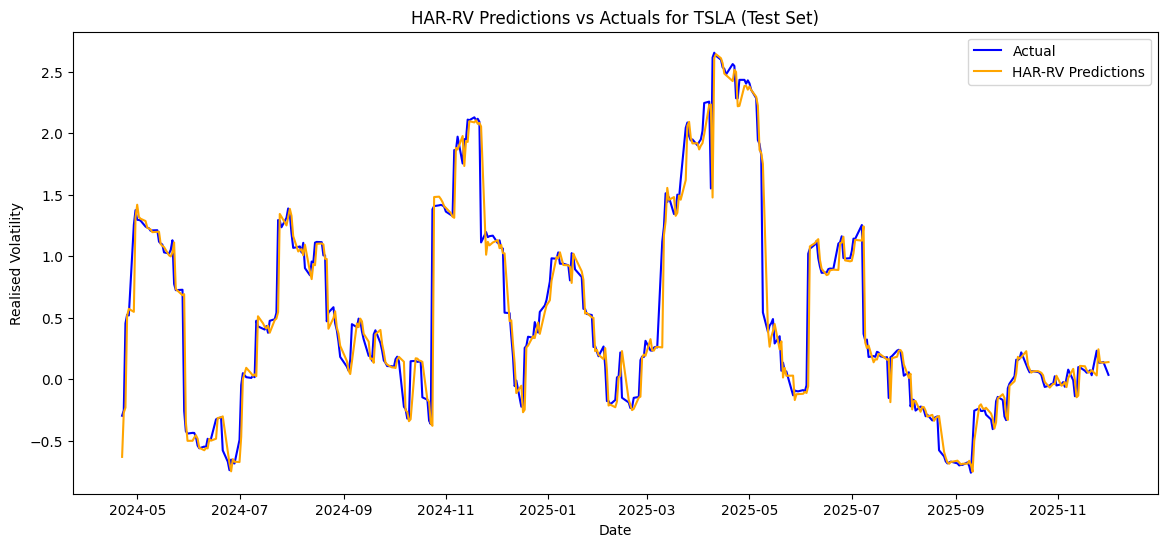

In [11]:
har_mae  = mean_absolute_error(har_test["RV"], har_preds)
har_rmse = np.sqrt(mean_squared_error(har_test["RV"], har_preds))

print(f"HAR-RV Model:")
print(f"\t'Test' MAE:  {har_mae:.6f}")
print(f"\t'Test' RMSE: {har_rmse:.6f}")

plt.figure(figsize=(14, 6))
plt.plot(har_test.index, har_test["RV"], label='Actual', color='blue')
plt.plot(har_test.index, har_preds, label='HAR-RV Predictions', color='orange')
plt.title(f'HAR-RV Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()


## 3. Machine Learning Models
### 3.1 Random Forest Regressor

In [12]:
# Prepare data for Random Forest

# 1. Get the 3D data from the datasets
X_train_3d = train_dataset.X.numpy()  # shape (num_samples, seq_len, num_features)
y_train = train_dataset.y.numpy().ravel()  # shape (num_samples, 1) => (num_samples,)

if val_dataset:
    X_val_3d = val_dataset.X.numpy()
    y_val = val_dataset.y.numpy().ravel()

X_test_3d = test_dataset.X.numpy()
y_test = test_dataset.y.numpy().ravel()

# 2. Flatten the time dimension for Random Forest
# We combine (seq_len * num_features) into a single feature vector
# Now RF sees: [Day_1_LogReturn, ..., Day_1_MACD, Day_2_LogReturn, ..., Day_30_MACD]
num_train_samples, seq_len, num_features = X_train_3d.shape
X_train_rf = X_train_3d.reshape(num_train_samples, seq_len * num_features)

if val_dataset:
    num_val_samples = X_val_3d.shape[0]
    X_val_rf = X_val_3d.reshape(num_val_samples, seq_len * num_features)

num_test_samples = X_test_3d.shape[0]
X_test_rf = X_test_3d.reshape(num_test_samples, seq_len * num_features)

Random Forest Regressor:
	Train MAE:  0.031647
	Train RMSE: 0.060921
	Test MAE:   0.112444
	Test RMSE:  0.209931


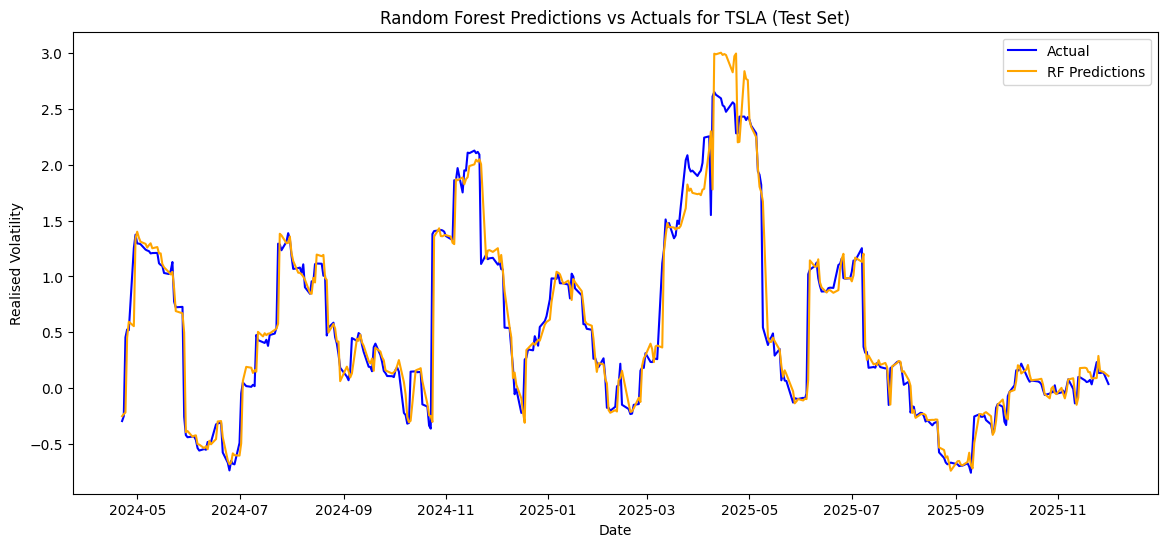

In [13]:
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_rf, train_dataset.y.ravel())

# Predict
rf_train_preds = rf.predict(X_train_rf)
rf_val_preds = rf.predict(X_val_rf) if val_dataset else None
rf_test_preds = rf.predict(X_test_rf)

# Evaluate
rf_train_mae = mean_absolute_error(train_dataset.y, rf_train_preds)
rf_train_rmse = np.sqrt(mean_squared_error(train_dataset.y, rf_train_preds))

rf_test_mae = mean_absolute_error(test_dataset.y, rf_test_preds)
rf_test_rmse = np.sqrt(mean_squared_error(test_dataset.y, rf_test_preds))

print(f"Random Forest Regressor:")
print(f"\tTrain MAE:  {rf_train_mae:.6f}")
print(f"\tTrain RMSE: {rf_train_rmse:.6f}")
print(f"\tTest MAE:   {rf_test_mae:.6f}")
print(f"\tTest RMSE:  {rf_test_rmse:.6f}")

# Plot predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(test_dataset.dates, test_dataset.y, label='Actual', color='blue')
plt.plot(test_dataset.dates, rf_test_preds, label='RF Predictions', color='orange')
# plt.plot(test_dataset.dates, base_preds, label='Naive Baseline', color='green', linestyle='--')
plt.title(f'Random Forest Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

### 3.2 LSTM

In [14]:
train_dataset, val_dataset, test_dataset = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.7,
    test_size=0.15,
)

batch_size = 32
train_ds = TimeSeriesDataset(train_dataset.X, train_dataset.y)
val_ds = TimeSeriesDataset(val_dataset.X, val_dataset.y) if val_dataset else None
test_ds = TimeSeriesDataset(test_dataset.X, test_dataset.y)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False) if val_ds else None
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


In [15]:
from src.lstm import LSTMRegressor

model = LSTMRegressor(
    input_size=len(feature_cols),
    hidden_size=32,
    num_layers=1,
    dropout=0.3
    )

model_name = f"{ticker}_best_lstm_model.pth"
metrics = train_lstm(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    lr=1e-3,
    model_name=model_name
)
train_loss_history, train_rmse_history, val_loss_history, val_rmse_history, val_mase_history = metrics

model.load_state_dict(torch.load(f"../models/{model_name}"))
lstm_preds, lstm_test_mae, lstm_test_rmse = evaluate_lstm(model, test_loader, test_dataset.y)

print(f"LSTM Regressor Test MAE:  {lstm_test_mae:.6f}")
print(f"LSTM Regressor Test RMSE: {lstm_test_rmse:.6f}")

/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/100 | Train RMSE: 0.176559 | Val RMSE: 0.162286
Epoch 20/100 | Train RMSE: 0.160450 | Val RMSE: 0.152244
Epoch 30/100 | Train RMSE: 0.152495 | Val RMSE: 0.155770
Early stopping at epoch 40. Best Val RMSE: 0.149025

Best model saved to ../models/TSLA_best_lstm_model.pth with Val RMSE: 0.149025


Training finished. Best model saved to ../models/TSLA_best_lstm_model.pth 
Best Val RMSE: 0.149025

LSTM Regressor Test MAE:  0.140330
LSTM Regressor Test RMSE: 0.219787


I tried using MASE (Mean Absolute Scaled Error) as an additional evaluation metric for the LSTM model. However, as volatility differences can be quite small, the MASE values turned out to be very large and not very informative in this context. 

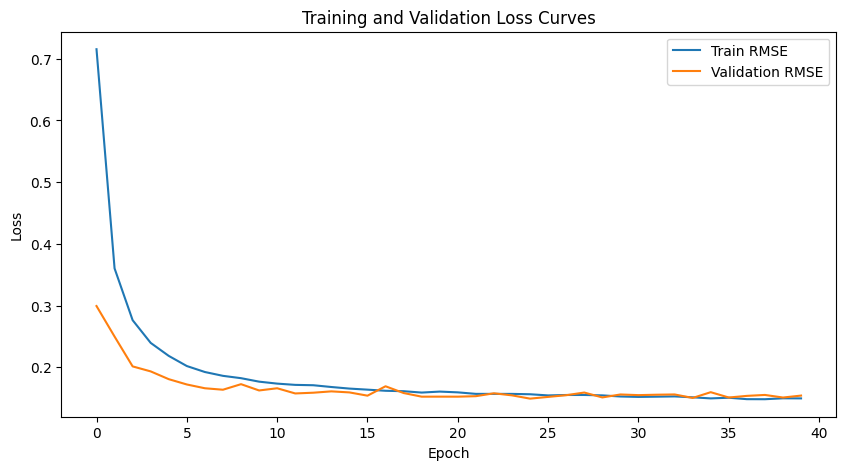

In [16]:
# Plot train and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

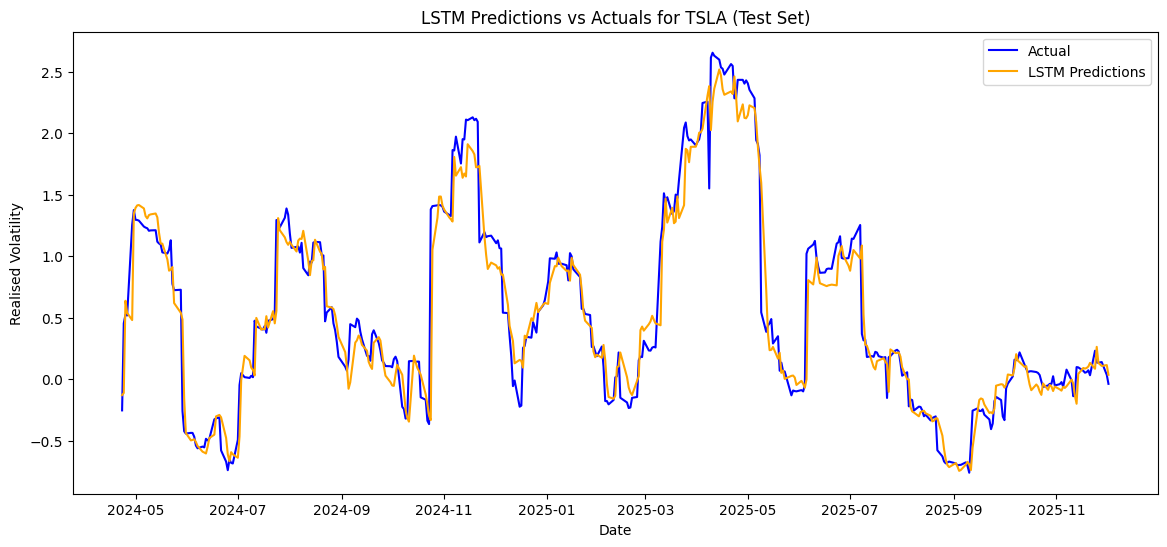

In [18]:
# Plot LSTM predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(test_dataset.dates, test_dataset.y, label='Actual', color='blue')
plt.plot(test_dataset.dates, lstm_preds, label='LSTM Predictions', color='orange')
plt.title(f'LSTM Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

### 4. Metrics Comparison

In [19]:
# Summarize results in a DataFrame
results = pd.DataFrame({
    'Model': ['Naive Baseline', 'HAR-RV', 'Random Forest', 'LSTM Regressor'],
    'Test MAE': [base_mae, har_mae, rf_test_mae, lstm_test_mae],
    'Test RMSE': [base_rmse, har_rmse, rf_test_rmse, lstm_test_rmse],
    'MAE Ratio': [base_mae / base_mae, har_mae / base_mae, rf_test_mae / base_mae, lstm_test_mae / base_mae],
    'RMSE Ratio': [base_rmse / base_rmse, har_rmse / base_rmse, rf_test_rmse / base_rmse, lstm_test_rmse / base_rmse],
})
results

,Model,Test MAE,Test RMSE,MAE Ratio,RMSE Ratio
0,Naive Baseline,0.101063,0.213259,1.000000,1.000000
1,HAR-RV,0.102755,0.211380,1.016740,0.991187
2,Random Forest,0.112444,0.209931,1.112616,0.984396
3,LSTM Regressor,0.140330,0.219787,1.388538,1.030610


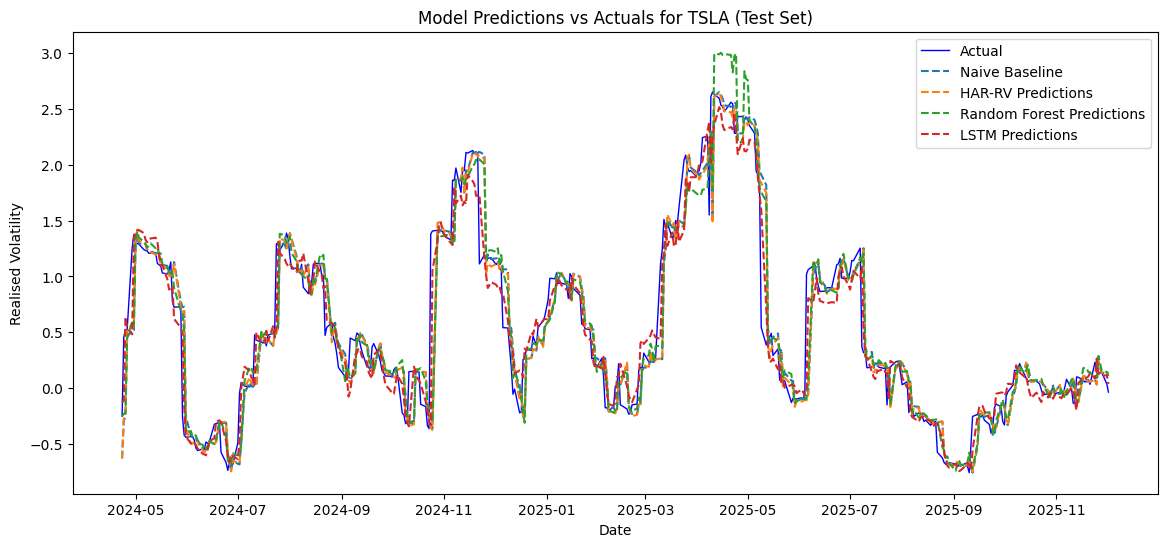

In [20]:
# Plot all model predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(test_dataset.dates, test_dataset.y, label='Actual', color='blue', linewidth=1)
plt.plot(test_dataset.dates, base_preds, label='Naive Baseline', linestyle='--')
plt.plot(test_dataset.dates, har_preds, label='HAR-RV Predictions', linestyle='--')
plt.plot(test_dataset.dates, rf_test_preds, label='Random Forest Predictions', linestyle='--')
plt.plot(test_dataset.dates, lstm_preds, label='LSTM Predictions', linestyle='--')
plt.title(f'Model Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()